In [108]:
import os, cv2
import numpy as np
import pandas as pd
import random
import csv

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import torch.serialization as tserial
import albumentations as album

from PIL import Image
from tqdm import tqdm
from lgbt import lgbt
from tifffile import imread, imwrite
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from pathlib import Path
from segmentation_models_pytorch.decoders.unet.model import Unet
from segmentation_models_pytorch import utils as smp_utils

In [109]:
TRAINING = True
EPOCHS = 50
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'

In [110]:
DATA_DIR = './massachusetts-roads-dataset/tiff/'
OUTPUT_DIR = './massachusetts-roads-dataset-processed/'
THRESHOLD = 0.98
WINDOW_SIZE = 224

In [111]:
def process_dataset(images_dir, masks_dir, output_images_dir, output_masks_dir):
    files_list = os.listdir(images_dir)
    random.shuffle(files_list)

    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_masks_dir, exist_ok=True)

    for image_path in files_list[: int(0.85 * len(files_list))]:
        img = cv2.imread(images_dir + "/" + image_path)
        label = cv2.imread(masks_dir + "/" + image_path[:-1], cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Couldn\'t load the image: {image_path}")
            return

        if label is None:
            print(f"Couldn\'t load the label {image_path}")
            return

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        white_pixel = np.array([255, 255, 255])
        crop_count = 0

        image_path = image_path[:-4]
        for y in range(0, img.shape[0] - WINDOW_SIZE + 1, WINDOW_SIZE):
            for x in range(0, img.shape[1] - WINDOW_SIZE + 1, WINDOW_SIZE):
                crop = img_rgb[y : y + WINDOW_SIZE, x : x + WINDOW_SIZE]

                white_pixels = np.sum(np.all(crop == white_pixel, axis=2))
                total_pixels = WINDOW_SIZE * WINDOW_SIZE
                non_white_ratio = 1 - (white_pixels / total_pixels)

                if non_white_ratio > THRESHOLD:
                    crop_bgr = cv2.cvtColor(crop, cv2.COLOR_RGB2BGR)
                    crop_label = label[y : y + WINDOW_SIZE, x : x + WINDOW_SIZE]
                    cv2.imwrite(
                        output_images_dir
                        + "/"
                        + image_path
                        + f"_crop_{crop_count}.png",
                        crop_bgr,
                    )
                    cv2.imwrite(
                        output_masks_dir
                        + "/"
                        + image_path
                        + f"_crop_{crop_count}.png",
                        crop_label,
                    )
                    crop_count += 1

        print(f"{crop_count} crops were saved in {image_path}")

In [112]:
train_images = os.path.join(DATA_DIR, 'train')
train_labels = os.path.join(DATA_DIR, 'train_labels')
output_train = os.path.join(OUTPUT_DIR, 'train')
output_labels = os.path.join(OUTPUT_DIR, 'train_labels')

print("Starting processing...")
process_dataset(train_images, train_labels, output_train, output_labels)
print("\nProcessing completed!")

Starting processing...
36 crops were saved in 24479230_15.
36 crops were saved in 24479005_15.
36 crops were saved in 25079290_15.
8 crops were saved in 20879005_15.
36 crops were saved in 24929185_15.
36 crops were saved in 11278720_15.
36 crops were saved in 21178915_15.
18 crops were saved in 17278765_15.
36 crops were saved in 15928870_15.
36 crops were saved in 23728975_15.
36 crops were saved in 18928765_15.
36 crops were saved in 22378900_15.
36 crops were saved in 22078945_15.
36 crops were saved in 18028885_15.
36 crops were saved in 20578915_15.
36 crops were saved in 20578900_15.
36 crops were saved in 21478900_15.
36 crops were saved in 17878795_15.
0 crops were saved in 10678885_15.
36 crops were saved in 10978675_15.
36 crops were saved in 22979020_15.
36 crops were saved in 22828975_15.
26 crops were saved in 11278885_15.
22 crops were saved in 18028960_15.
36 crops were saved in 23878810_15.
36 crops were saved in 22828885_15.
36 crops were saved in 22229410_15.
36 crop

In [113]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [114]:
class_dict = pd.read_csv("./massachusetts-roads-dataset/label_class_dict.csv")
select_classes = class_dict['name'].tolist()
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('Class Names: ', select_classes)
print('Class RGB values: ', class_rgb_values)

Class Names:  ['background', 'road']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [115]:
select_class_indices = [select_classes.index(cls.lower()) for cls in select_classes]
select_class_rgb_values = np.array(class_rgb_values)[select_class_indices]

In [116]:
def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

In [117]:
def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return semantic_map
    
def reverse_one_hot(image):
    x = np.argmax(image, axis = -1)
    return x

def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]
    return x

In [118]:
class RoadsDataset(torch.utils.data.Dataset):
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir)) if not image_id.startswith('.')]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir)) if not image_id.startswith('.')]
            
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[i], cv2.IMREAD_GRAYSCALE)
        
        mask = (mask > 127).astype('float32')
        
        if image.shape[:2] != mask.shape[:2]:
            mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        mask = np.expand_dims(mask, axis=-1)
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.image_paths)

In [119]:
dataset = RoadsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

# visualize(
#     original_image = image,
#     ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
#     one_hot_encoded_mask = reverse_one_hot(mask)
# )

In [120]:
def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=224, width=224, always_apply=True),
        album.OneOf([
            album.HorizontalFlip(p=0.5),
            album.VerticalFlip(p=0.5),
            album.RandomRotate90(p=0.5),
        ], p=0.75),
        album.RandomBrightnessContrast(p=0.2),
        album.GaussianBlur(p=0.1)
    ]
    return album.Compose(train_transform, is_check_shapes=False)

def get_validation_augmentation():   
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform, is_check_shapes=False)

def to_tensor(x, **kwargs):
    if len(x.shape) == 3:
        return x.transpose(2, 0, 1).astype('float32')
    else:
        return x.astype('float32')

def get_preprocessing(preprocessing_fn=None): 
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
    return album.Compose(_transform)

In [121]:
augmented_dataset = RoadsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# for i in range(3):
#     image, mask = augmented_dataset[random_idx]
#     visualize(
#         original_image = image,
#         ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
#         one_hot_encoded_mask = reverse_one_hot(mask)
#     )

/tmp/ipykernel_26244/2841564488.py:3: UserWarning: Argument(s) 'always_apply' are not valid for transform RandomCrop
  album.RandomCrop(height=224, width=224, always_apply=True),


In [122]:
# Test the dataset
test_dataset = RoadsDataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Check a sample
image, mask = test_dataset[0]
print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")
print(f"Unique mask values: {np.unique(mask)}")

Image shape: (3, 224, 224)
Mask shape: (1, 224, 224)
Unique mask values: [0. 1.]


/tmp/ipykernel_26244/2841564488.py:3: UserWarning: Argument(s) 'always_apply' are not valid for transform RandomCrop
  album.RandomCrop(height=224, width=224, always_apply=True),


In [123]:
model = Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [124]:
train_dataset = RoadsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = RoadsDataset(
    x_valid_dir, y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/tmp/ipykernel_26244/2841564488.py:3: UserWarning: Argument(s) 'always_apply' are not valid for transform RandomCrop
  album.RandomCrop(height=224, width=224, always_apply=True),
/tmp/ipykernel_26244/2841564488.py:16: UserWarning: Argument(s) 'always_apply' are not valid for transform PadIfNeeded
  album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),


In [125]:
# def calculate_class_weights(masks_dir, class_rgb_values):
#     class_counts = np.zeros(len(class_rgb_values))
#     total_pixels = 0
    
#     mask_paths = [os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if not f.startswith('.')]
    
#     for mask_path in tqdm(mask_paths, desc='Calculating class weights'):
#         mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#         mask = (mask > 127).astype('float32')
#         mask = np.expand_dims(mask, axis=-1)
#         one_hot_mask = one_hot_encode(mask, class_rgb_values)
        
#         for class_idx in range(len(class_rgb_values)):
#             class_counts[class_idx] += np.sum(one_hot_mask[..., class_idx])
        
#         total_pixels += mask.size
    
#     class_weights = total_pixels / (len(class_rgb_values) * class_counts)
#     class_weights = np.nan_to_num(class_weights, nan=0.0, posinf=0.0, neginf=0.0)
    
#     class_weights = class_weights / np.sum(class_weights) * len(class_rgb_values)
    
#     print(f"Class counts: {class_counts}")
#     print(f"Class weights: {class_weights}")
    
#     return torch.tensor(class_weights, dtype=torch.float32), class_counts

In [126]:
# class_weights, class_counts = calculate_class_weights(y_train_dir, select_class_rgb_values)
# pos_weight = class_weights[1] / class_weights[0]
# print(f'Calculated positive weight: {pos_weight}')

In [127]:
# plt.figure(figsize=(10, 5))
# plt.bar(['Background', 'Road'], class_counts.numpy())
# plt.title('Class Distribution')
# plt.ylabel('Pixel Count')
# plt.show()

In [128]:
class SoftBCEWithLogitsLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce_loss = smp.losses.SoftBCEWithLogitsLoss(
            ignore_index=None,
            pos_weight=torch.Tensor([2.0])
            )
        self.__name__ = 'soft_bce_with_logits'

    def forward(self, y_pred, y_true):
        return self.bce_loss(y_pred, y_true)

In [129]:
loss = SoftBCEWithLogitsLoss()

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
    smp.utils.metrics.Precision(threshold=0.5),
    smp.utils.metrics.Recall(threshold=0.5)
]

optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.00008)])

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)

In [130]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)
valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [131]:
if TRAINING:
    best_iou_score = 0.0
    train_logs_list, valid_logs_list, lr_logs_list = [], [], []
    for i in lgbt(range(0, EPOCHS)):
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)

        lr_scheduler.step()
        current_lr = lr_scheduler.get_last_lr()[0]
        print(f'Current LR: {current_lr}')

        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)
        lr_logs_list.append(current_lr)

        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|█████████████████████| 14/14 [00:01<00:00,  9.77it/s, soft_bce_with_logits - 0.8422, iou_score - 0.3135, fscore - 0.4753, precision - 0.4696, recall - 0.4983]
Current LR: 8e-05
Model saved!
🌈            :002% ▋                                                       [1/50] [8.02s, 0.12it/s]  
Epoch: 1
valid: 100%|█████████████████████| 14/14 [00:01<00:00,  9.85it/s, soft_bce_with_logits - 0.8138, iou_score - 0.4162, fscore - 0.5865, precision - 0.5121, recall - 0.6945]
Current LR: 6.500000000000001e-05
Model saved!
🌈            :004% ▋▋                                                      [2/50] [16.01s, 0.12it/s]  
Epoch: 2
valid: 100%|█████████████████████| 14/14 [00:01<00:00,  9.83it/s, soft_bce_with_logits - 0.7945, iou_score - 0.4534, fscore - 0.6218, precision - 0.6059, recall - 0.6439]
Current LR: 8e-05
Model saved!
🌈            :006% ▋▋▋                                                     [3/50] [24.02s, 0.12it/s]  
Epoch: 3
valid: 100%|█████████████████████

valid: 100%|████████████████████████| 14/14 [00:01<00:00,  9.79it/s, soft_bce_with_logits - 0.7223, iou_score - 0.538, fscore - 0.696, precision - 0.802, recall - 0.6203]
Current LR: 7.971177920604846e-05
🌈            :032% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋                                      [16/50] [127.18s, 0.13it/s]  
Epoch: 16
valid: 100%|█████████████████████| 14/14 [00:01<00:00,  9.76it/s, soft_bce_with_logits - 0.7213, iou_score - 0.5379, fscore - 0.6964, precision - 0.7777, recall - 0.6359]
Current LR: 7.885819298766931e-05
🌈            :034% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋                                     [17/50] [135.06s, 0.13it/s]  
Epoch: 17
valid: 100%|██████████████████████| 14/14 [00:01<00:00,  9.63it/s, soft_bce_with_logits - 0.7199, iou_score - 0.5577, fscore - 0.7132, precision - 0.7668, recall - 0.671]
Current LR: 7.747204418453818e-05
Model saved!
🌈            :036% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋                                    [18/50] [143.12s, 0.13it/s]  
Epoch: 18
valid: 100%|███████████████

In [132]:
best_model = torch.load('./best_model.pth', map_location=DEVICE, weights_only=False)

In [133]:
test_dataset = RoadsDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

test_dataset_vis = RoadsDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

# visualize(
#     original_image = image,
#     ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
#     one_hot_encoded_mask = reverse_one_hot(mask)
# )

/tmp/ipykernel_26244/2841564488.py:16: UserWarning: Argument(s) 'always_apply' are not valid for transform PadIfNeeded
  album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),


In [134]:
def crop_image(image, target_image_dims=[1536,1536,3]):
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2
    if padding<0:
        return image
    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [135]:
sample_preds_folder = './sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [136]:
for idx in range(len(test_dataset)):
    image, gt_mask = test_dataset[idx]
    image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    
    pred_mask = best_model(x_tensor)
    
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    pred_mask = (pred_mask > 0.5).astype('uint8')
    
    gt_mask = gt_mask.squeeze()
    
    cv2.imwrite(
        os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"),
        np.hstack([
            image_vis,
            cv2.cvtColor((gt_mask * 255).astype('uint8'), cv2.COLOR_GRAY2BGR),
            cv2.cvtColor((pred_mask * 255).astype('uint8'), cv2.COLOR_GRAY2BGR)
        ])
    )

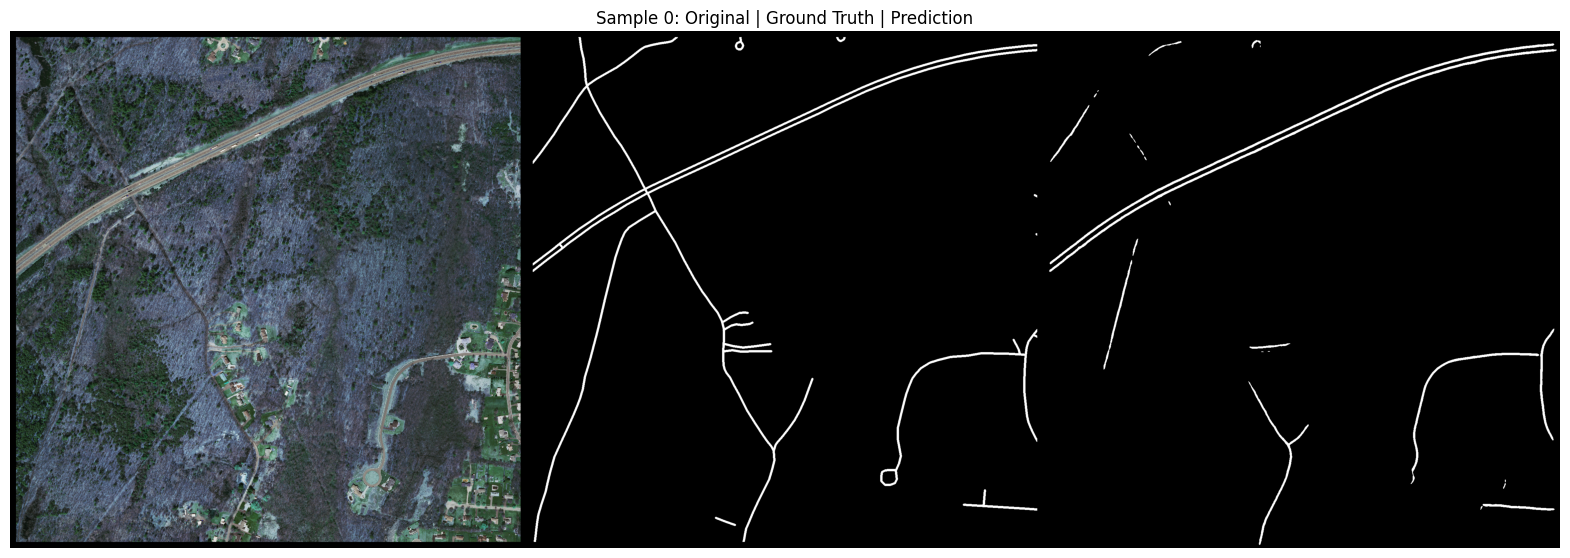

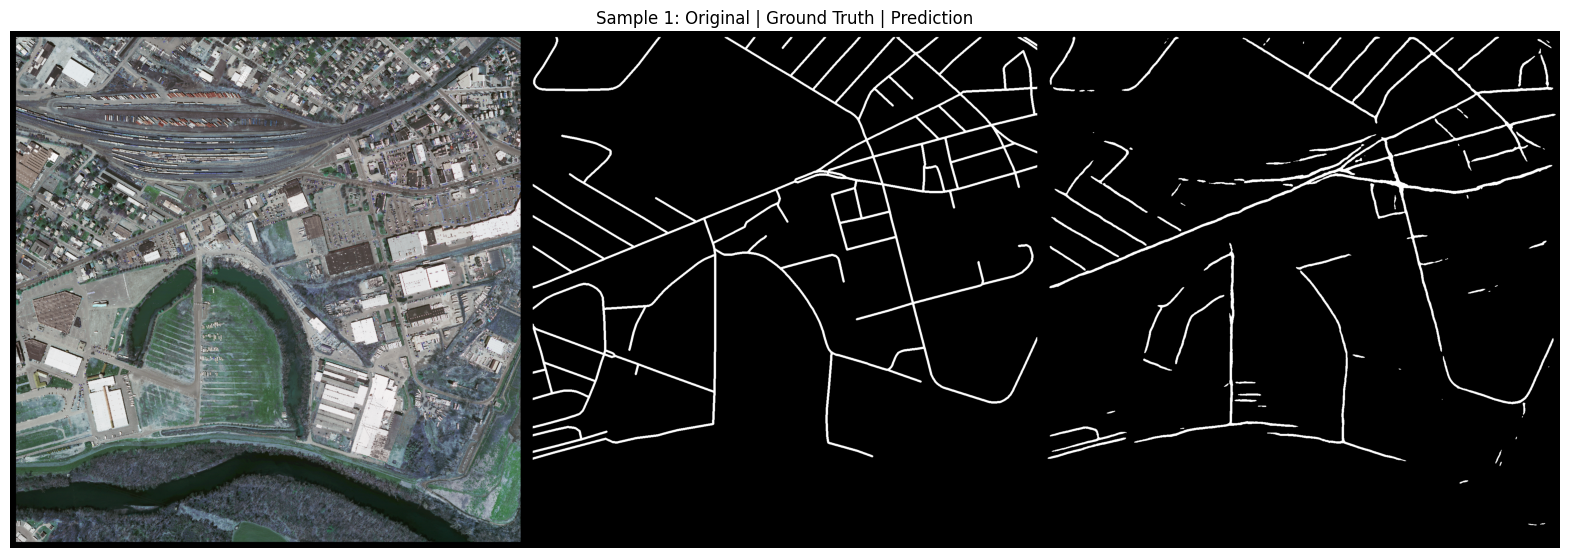

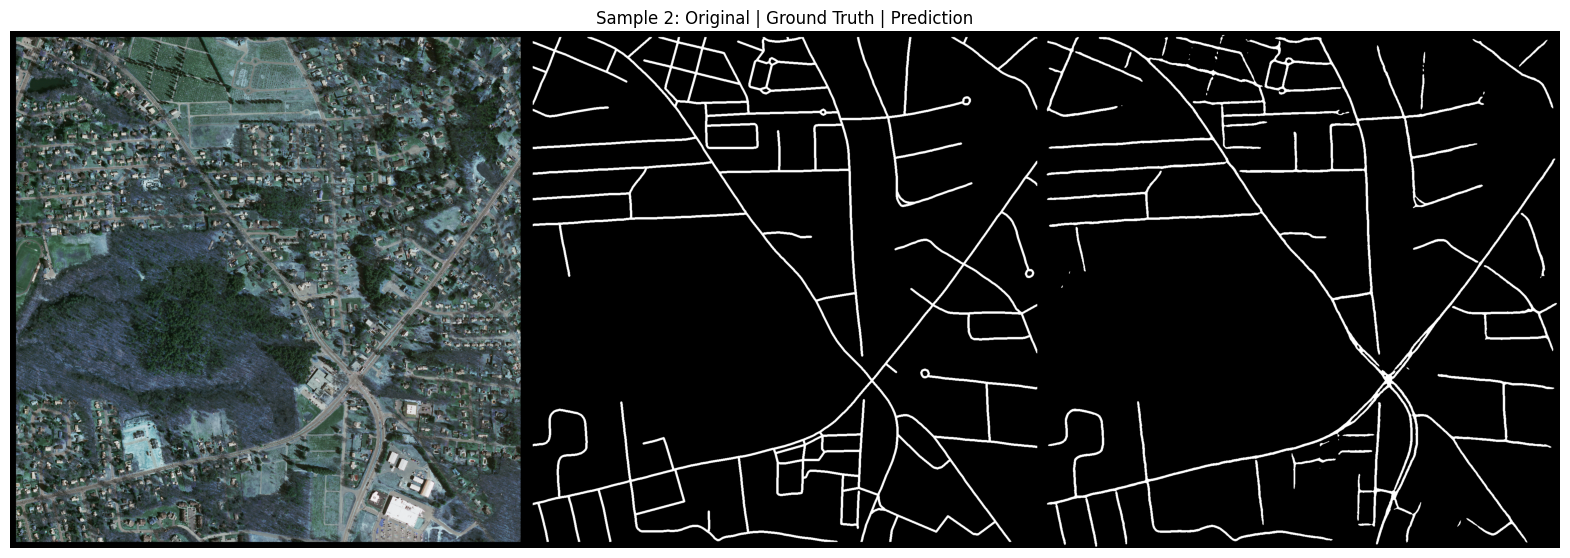

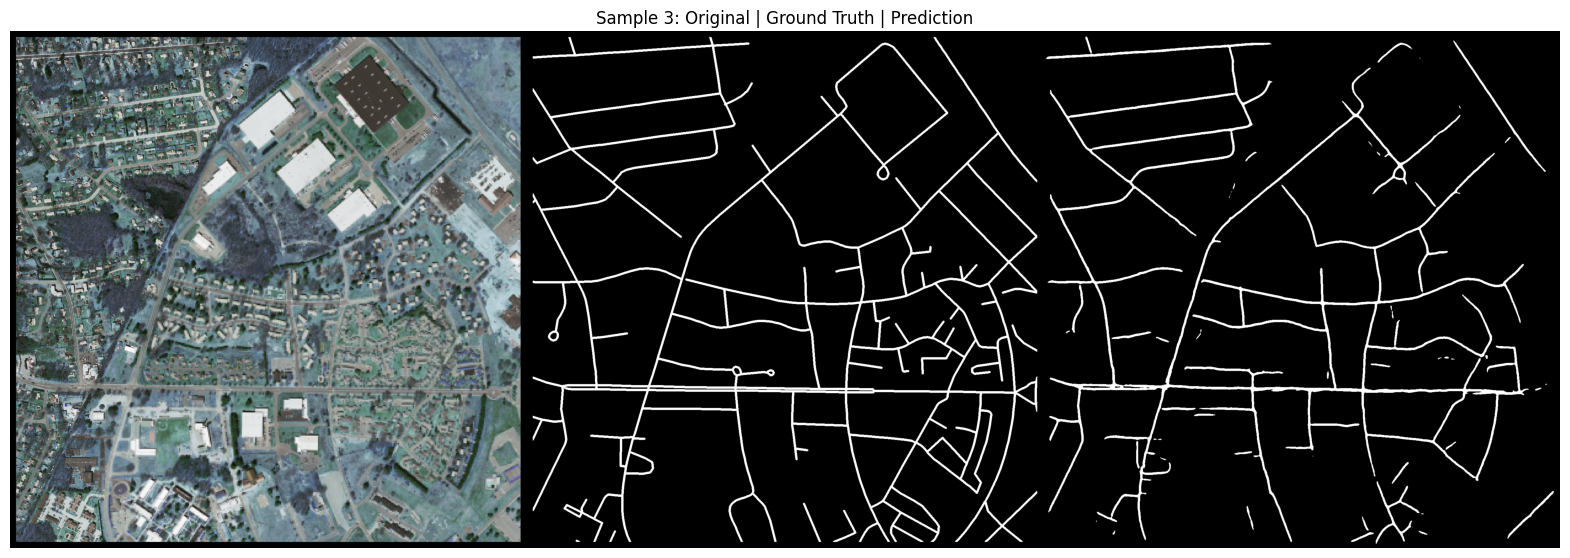

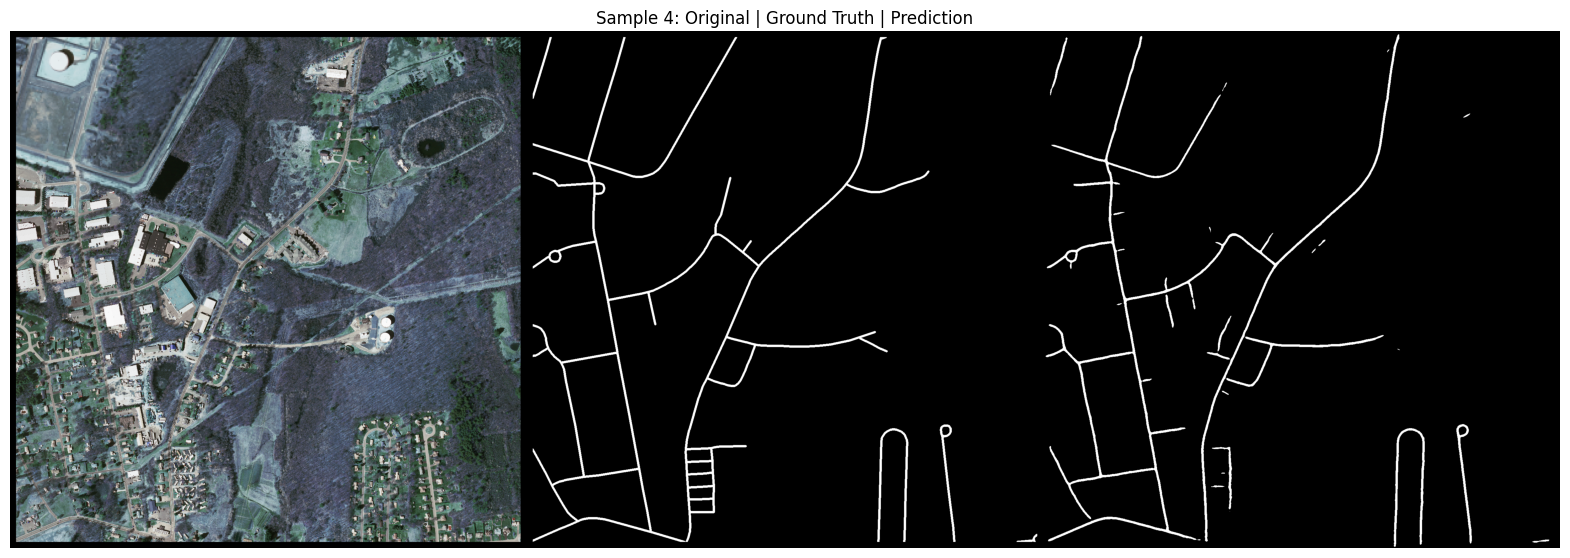

In [137]:
for idx in range(min(5, len(test_dataset))):
    pred_img = cv2.imread(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"))
    plt.figure(figsize=(20, 10))
    plt.imshow(cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Sample {idx}: Original | Ground Truth | Prediction")
    plt.axis('off')
    plt.show()

In [138]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)

valid: 100%|█████████████████████| 49/49 [00:06<00:00,  7.68it/s, soft_bce_with_logits - 0.7057, iou_score - 0.5968, fscore - 0.7434, precision - 0.8219, recall - 0.6842]


In [139]:
print("Evaluation on Test Data: ")

for log in valid_logs:
    print(f"Mean {log}: {valid_logs[log]:.4f}")

Evaluation on Test Data: 
Mean soft_bce_with_logits: 0.7057
Mean iou_score: 0.5968
Mean fscore: 0.7434
Mean precision: 0.8219
Mean recall: 0.6842


<Axes: >

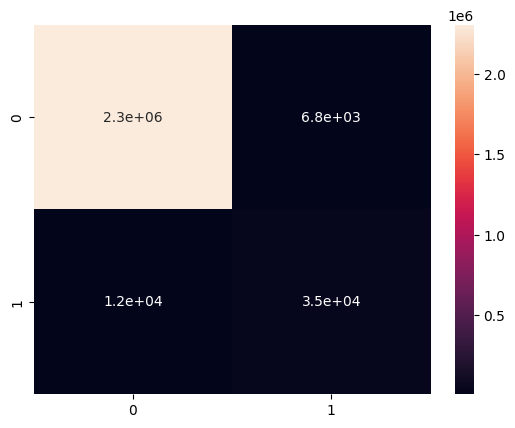

In [140]:
cm = confusion_matrix(gt_mask.flatten(), pred_mask.flatten())
sns.heatmap(cm, annot=True)

In [141]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
lr_logs_df = pd.DataFrame(lr_logs_list)

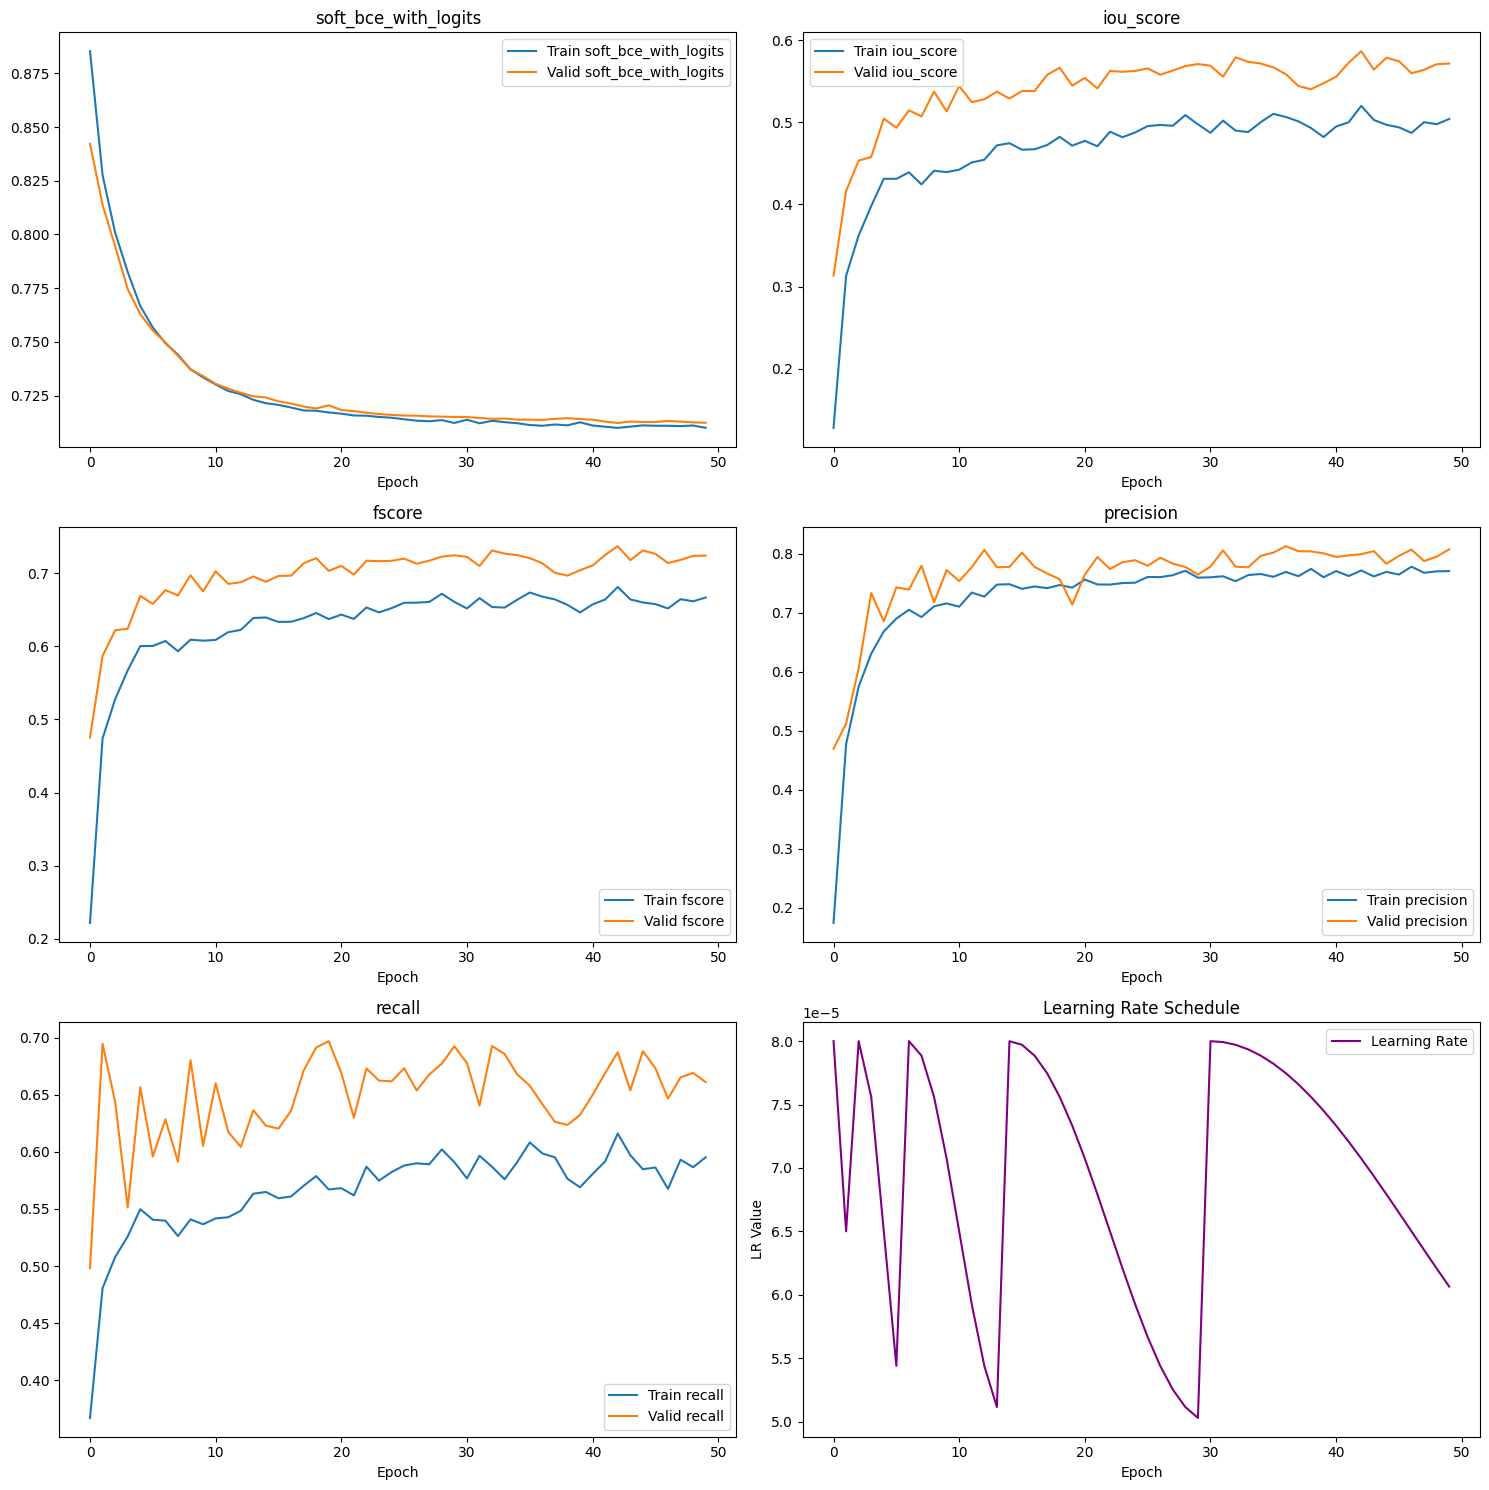

In [142]:
metrics_to_plot = [m for m in train_logs_df.columns]
num_metrics = len(metrics_to_plot)

rows = int(np.ceil(num_metrics / 2))
cols = min(2, num_metrics)

plt.figure(figsize=(15, 5 * rows))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(rows, cols, i)
    plt.plot(train_logs_df[metric], label=f'Train {metric}')
    plt.plot(valid_logs_df[metric], label=f'Valid {metric}')
    plt.title(metric)
    plt.xlabel('Epoch')
    plt.legend()

plt.subplot(rows, cols, num_metrics + 1)
plt.plot(lr_logs_df, label='Learning Rate', color='purple')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('LR Value')
plt.legend()

plt.tight_layout()
plt.show()